# Домашнее задание  № 5. Матричные разложения/Тематическое моделирование

### Задание № 1 (8 баллов)

Попробуйте матричные разложения с 4 классификаторами - SGDClassifier, KNeighborsClassifier,  RandomForest, ExtraTreesClassifier (про него подробнее почитайте в документации, он похож на RF). Используйте и NMF, SVD и LDA. Сравните результаты на кросс-валидации и выберите лучшее сочетание.

В итоге у вас должно получиться, как минимум 12 моделей (три разложения на каждый классификатор). Используйте 1 и те же параметры кросс-валидации. Параметры векторизации, параметры K в матричных разложениях, параметры классификаторов могут быть разными между экспериментами.

Можете взять поменьше данных, если все будет обучаться слишком долго (не ставьте параметр K слишком большим в NMF и LDA, иначе точно будет слишком долго)

---------

#### Выводы

Пробовал разные параметры для каждого классификатора, для некоторых удалось улучшить результат с +-0,5 до 0,6-0,7, но не для всех. Лучше всего показали себя SVD разложение совместно с SGDClassifier и RandomForest классификаторами. 

In [ ]:
#!pip install gensim pymorphy2 seaborn pyLDAvis
#!pip install --upgrade pymorphy3


In [23]:
import gensim
import pandas as pd
import numpy as np
from pymorphy3 import MorphAnalyzer
import pyLDAvis.gensim_models
from collections import Counter
from string import punctuation
from razdel import tokenize as razdel_tokenize
from IPython.display import Image
from IPython.core.display import HTML 
from sklearn.decomposition import TruncatedSVD, NMF, PCA, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier

In [16]:
morph = MorphAnalyzer()

In [5]:
# добавим лемматизацию
def normalize(text):
    normalized_text = [word.text.strip(punctuation) for word \
                                                            in razdel_tokenize(text)]
    normalized_text = [word.lower() for word in normalized_text if word and len(word) < 20 ]
    normalized_text = [morph.parse(word)[0].normal_form for word in normalized_text]
    return ' '.join(normalized_text)

In [7]:
data = pd.read_csv('data/avito_category_classification.csv')

In [8]:
data

,category_name,description
0,Автомобили,"отличное состояние,обслужиание в салоне"
1,Детская одежда и обувь,В отличном состоянии. Фирма KIKO. Очень теплый...
2,Предложение услуг,"Изготовление ограждений, перил,качелей, турник..."
3,Автомобили,Автомобиль в отличном техническом состоянии. О...
4,Бытовая техника,"Продается газовая плита ""Гефест"" (Белоруссия) ..."
...,...,...
9893,Товары для детей и игрушки,Чтобы посмотреть весь ассортимент нашего магаз...
9894,Детская одежда и обувь,"Весна,осень.74-80.вопросы можно в вайбер,двухс..."
9895,"Одежда, обувь, аксессуары","Кимоно Green Hill. Состояние отличное, рост ..."
9896,Детская одежда и обувь,Б/у кроссовки на девочку. Носили только в спор...


In [141]:
pipeline_svd_rfc = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=10))
])

pipeline_svd_knc = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', KNeighborsClassifier(n_neighbors=20, metric='cosine'))
])

pipeline_svd_etc = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0))
])

pipeline_svd_sgd = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', SGDClassifier(loss="hinge", penalty="l2", max_iter=100))
])

pipeline_nmf_rfc = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', RandomForestClassifier(n_estimators=200, max_depth=6))
])

pipeline_nmf_knc = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', KNeighborsClassifier(n_neighbors=20, metric='cosine'))
])

pipeline_nmf_etc = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0))
])

pipeline_nmf_sgd = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', SGDClassifier(loss="hinge", penalty="l2", max_iter=1000))
])

pipeline_lda_rfc = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', LatentDirichletAllocation(50)),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=10))
])

pipeline_lda_knc = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', LatentDirichletAllocation(50)),
    ('clf', KNeighborsClassifier(n_neighbors=10, metric='cosine'))
])

pipeline_lda_etc = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', LatentDirichletAllocation(50)),
    ('clf', ExtraTreesClassifier(n_estimators=100, max_depth=10, min_samples_split=2, random_state=0))
])

pipeline_lda_sgd = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', LatentDirichletAllocation(50)),
    ('clf', SGDClassifier(loss="hinge", penalty="l2", max_iter=1))
])

In [17]:
data['description_norm'] = data['description'].apply(normalize)

In [19]:
def eval_table(X, y, pipeline, N=6):
    # зафиксируем порядок классов
    labels = list(set(y))
    
    # метрики отдельных фолдов будет хранить в табличке
    fold_metrics = pd.DataFrame(index=labels)
    # дополнительно также соберем таблицу ошибок
    errors = np.zeros((len(labels), len(labels)))
    
    # создаем стратегию кросс-валидации
    # shuffle=True (перемешивание) - часто критично важно указать
    # т.к. данные могут быть упорядочены и модель на этом обучится
    kfold = StratifiedKFold(n_splits=N, shuffle=True, )
    
    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        # fit-predict как и раньше, но сразу пайплайном
        pipeline.fit(X[train_index], y[train_index])
        preds = pipeline.predict(X[test_index])
        
        # записываем метрику и индекс фолда
        fold_metrics[f'precision_{i}'] = precision_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'recall_{i}'] = recall_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'f1_{i}'] = f1_score(y[test_index], preds, labels=labels, average=None)
        errors += confusion_matrix(y[test_index], preds, labels=labels, normalize='true')
    
    # таблица для усредненных значений
    # тут мы берем колонки со значениями и усредняем их
    # часто также все метрики сразу суммируют и в конце просто делят на количество фолдов
    # но мы тут помимо среднего также хотим посмотреть на стандартное отклонение
    # чтобы понять как сильно варьируются оценки моделей
    result = pd.DataFrame(index=labels)
    result['precision'] = fold_metrics[[f'precision_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['precision_std'] = fold_metrics[[f'precision_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['recall'] = fold_metrics[[f'recall_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['recall_std'] = fold_metrics[[f'recall_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['f1'] = fold_metrics[[f'f1_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['f1_std'] = fold_metrics[[f'f1_{i}' for i in range(N)]].std(axis=1).round(2)
    
    # добавим одну колонку со средним по всем классам
    result.loc['mean'] = result.mean().round(2)
    # проценты ошибок просто усредняем
    errors /= N
    
    return result, errors

-------------------

Запускаем классификаторы

In [55]:
metrics_svd_knc, errors_svd_knc = eval_table(data['description_norm'], data['category_name'], pipeline_svd_knc)

c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525

In [20]:
metrics_svd_rfc, errors_svd_rfc = eval_table(data['description_norm'], data['category_name'], pipeline_svd_rfc)

c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525

In [93]:
metrics_svd_etc, errors_svd_etc = eval_table(data['description_norm'], data['category_name'], pipeline_svd_etc)

c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525

In [94]:
metrics_svd_sgd, errors_svd_sgd = eval_table(data['description_norm'], data['category_name'], pipeline_svd_sgd)

c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525

In [28]:
metrics_nmf_rfc, errors_nmf_rfc = eval_table(data['description_norm'], data['category_name'], pipeline_nmf_rfc)

c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c

In [98]:
metrics_nmf_knc, errors_nmf_knc = eval_table(data['description_norm'], data['category_name'], pipeline_nmf_knc)

c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525

In [101]:
metrics_nmf_etc, errors_nmf_etc = eval_table(data['description_norm'], data['category_name'], pipeline_nmf_etc)

c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525

In [107]:
metrics_nmf_sgd, errors_nmf_sgd = eval_table(data['description_norm'], data['category_name'], pipeline_nmf_sgd)

c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c

In [133]:
metrics_lda_rfc, errors_lda_rfc = eval_table(data['description_norm'], data['category_name'], pipeline_lda_rfc)

c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525

In [134]:
metrics_lda_knc, errors_lda_knc = eval_table(data['description_norm'], data['category_name'], pipeline_lda_knc)

c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525

In [135]:
metrics_lda_etc, errors_lda_etc = eval_table(data['description_norm'], data['category_name'], pipeline_lda_etc)

c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. U

In [142]:
metrics_lda_sgd, errors_lda_sgd = eval_table(data['description_norm'], data['category_name'], pipeline_lda_sgd)

c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since

-------------

Смотрим результаты

In [21]:
metrics_svd_rfc

,precision,precision_std,recall,recall_std,f1,f1_std
Квартиры,0.87,0.04,0.89,0.02,0.88,0.02
Товары для детей и игрушки,0.81,0.09,0.19,0.03,0.31,0.04
Ремонт и строительство,0.78,0.12,0.09,0.03,0.17,0.05
Телефоны,0.94,0.03,0.33,0.05,0.49,0.06
Бытовая техника,0.87,0.21,0.06,0.04,0.11,0.07
Детская одежда и обувь,0.45,0.01,0.69,0.03,0.55,0.01
Автомобили,0.88,0.04,0.57,0.07,0.69,0.04
Предложение услуг,0.74,0.05,0.46,0.09,0.56,0.07
Мебель и интерьер,0.76,0.39,0.04,0.02,0.08,0.04
"Одежда, обувь, аксессуары",0.47,0.01,0.77,0.01,0.58,0.01


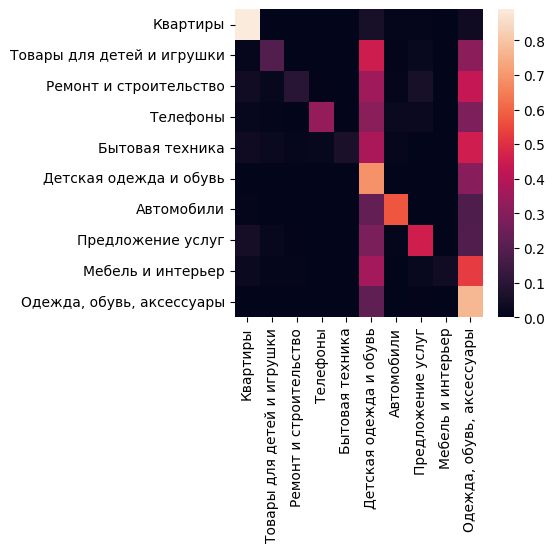

In [22]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_svd_rfc, xticklabels=metrics_svd_rfc.index.tolist()[:-1], 
            yticklabels=metrics_svd_rfc.index.tolist()[:-1])
plt.show()

In [56]:
metrics_svd_knc

,precision,precision_std,recall,recall_std,f1,f1_std
Квартиры,0.94,0.02,0.88,0.02,0.91,0.02
Товары для детей и игрушки,0.69,0.07,0.35,0.03,0.47,0.04
Ремонт и строительство,0.54,0.15,0.16,0.05,0.25,0.07
Телефоны,0.78,0.04,0.43,0.04,0.56,0.04
Бытовая техника,0.53,0.09,0.24,0.03,0.33,0.04
Детская одежда и обувь,0.52,0.01,0.69,0.03,0.59,0.02
Автомобили,0.74,0.04,0.70,0.04,0.72,0.03
Предложение услуг,0.60,0.05,0.71,0.05,0.65,0.05
Мебель и интерьер,0.49,0.06,0.28,0.04,0.35,0.04
"Одежда, обувь, аксессуары",0.51,0.01,0.65,0.02,0.57,0.01


In [95]:
metrics_svd_etc

,precision,precision_std,recall,recall_std,f1,f1_std
Квартиры,0.71,0.03,0.78,0.02,0.74,0.02
Товары для детей и игрушки,0.67,0.05,0.16,0.03,0.26,0.04
Ремонт и строительство,0.62,0.14,0.08,0.03,0.14,0.05
Телефоны,0.87,0.08,0.33,0.05,0.48,0.06
Бытовая техника,0.53,0.12,0.13,0.04,0.21,0.05
Детская одежда и обувь,0.43,0.02,0.70,0.03,0.53,0.02
Автомобили,0.83,0.04,0.44,0.05,0.58,0.05
Предложение услуг,0.85,0.06,0.28,0.04,0.42,0.04
Мебель и интерьер,0.72,0.11,0.13,0.04,0.22,0.06
"Одежда, обувь, аксессуары",0.47,0.01,0.72,0.02,0.57,0.01


In [96]:
metrics_svd_sgd

,precision,precision_std,recall,recall_std,f1,f1_std
Квартиры,0.96,0.01,0.96,0.01,0.96,0.00
Товары для детей и игрушки,0.71,0.07,0.65,0.03,0.68,0.03
Ремонт и строительство,0.60,0.06,0.49,0.07,0.53,0.03
Телефоны,0.81,0.04,0.79,0.04,0.80,0.02
Бытовая техника,0.69,0.11,0.50,0.03,0.58,0.04
Детская одежда и обувь,0.74,0.02,0.77,0.02,0.75,0.01
Автомобили,0.86,0.05,0.89,0.04,0.88,0.03
Предложение услуг,0.79,0.04,0.75,0.03,0.77,0.02
Мебель и интерьер,0.69,0.07,0.63,0.06,0.66,0.04
"Одежда, обувь, аксессуары",0.72,0.02,0.77,0.04,0.74,0.02


In [40]:
metrics_nmf_rfc

,precision,precision_std,recall,recall_std,f1,f1_std
Квартиры,0.89,0.04,0.95,0.04,0.91,0.02
Товары для детей и игрушки,0.88,0.05,0.36,0.07,0.51,0.07
Ремонт и строительство,0.70,0.24,0.06,0.03,0.11,0.04
Телефоны,0.93,0.06,0.33,0.08,0.48,0.09
Бытовая техника,0.44,0.50,0.02,0.02,0.04,0.05
Детская одежда и обувь,0.62,0.06,0.70,0.06,0.66,0.03
Автомобили,0.88,0.02,0.75,0.07,0.81,0.04
Предложение услуг,0.71,0.04,0.51,0.04,0.59,0.02
Мебель и интерьер,0.75,0.11,0.20,0.11,0.30,0.13
"Одежда, обувь, аксессуары",0.45,0.03,0.82,0.05,0.58,0.01


In [100]:
metrics_nmf_knc

,precision,precision_std,recall,recall_std,f1,f1_std
Квартиры,0.87,0.03,0.84,0.06,0.85,0.03
Товары для детей и игрушки,0.57,0.06,0.34,0.07,0.42,0.06
Ремонт и строительство,0.28,0.06,0.18,0.05,0.22,0.06
Телефоны,0.60,0.06,0.47,0.04,0.52,0.03
Бытовая техника,0.29,0.10,0.22,0.07,0.24,0.05
Детская одежда и обувь,0.55,0.02,0.60,0.03,0.57,0.02
Автомобили,0.55,0.04,0.68,0.02,0.61,0.03
Предложение услуг,0.52,0.04,0.59,0.04,0.55,0.03
Мебель и интерьер,0.41,0.08,0.24,0.05,0.30,0.05
"Одежда, обувь, аксессуары",0.51,0.02,0.63,0.01,0.57,0.01


In [102]:
metrics_nmf_etc

,precision,precision_std,recall,recall_std,f1,f1_std
Квартиры,0.91,0.01,0.97,0.01,0.94,0.01
Товары для детей и игрушки,0.75,0.02,0.61,0.03,0.67,0.03
Ремонт и строительство,0.60,0.04,0.45,0.05,0.51,0.04
Телефоны,0.78,0.04,0.79,0.05,0.78,0.02
Бытовая техника,0.70,0.09,0.29,0.06,0.41,0.06
Детская одежда и обувь,0.74,0.01,0.77,0.04,0.75,0.02
Автомобили,0.86,0.01,0.91,0.04,0.88,0.02
Предложение услуг,0.71,0.02,0.74,0.06,0.73,0.04
Мебель и интерьер,0.71,0.04,0.56,0.04,0.62,0.03
"Одежда, обувь, аксессуары",0.70,0.01,0.81,0.01,0.75,0.01


In [114]:
metrics_nmf_sgd

,precision,precision_std,recall,recall_std,f1,f1_std
Квартиры,0.72,0.12,0.95,0.07,0.81,0.07
Товары для детей и игрушки,0.73,0.27,0.36,0.25,0.38,0.16
Ремонт и строительство,0.30,0.19,0.13,0.16,0.13,0.12
Телефоны,0.67,0.19,0.61,0.19,0.60,0.08
Бытовая техника,0.70,0.34,0.03,0.02,0.06,0.03
Детская одежда и обувь,0.61,0.12,0.68,0.12,0.63,0.04
Автомобили,0.77,0.12,0.76,0.07,0.76,0.05
Предложение услуг,0.69,0.38,0.17,0.26,0.20,0.22
Мебель и интерьер,0.68,0.21,0.32,0.19,0.37,0.11
"Одежда, обувь, аксессуары",0.60,0.14,0.67,0.19,0.60,0.04


In [140]:
metrics_lda_rfc

,precision,precision_std,recall,recall_std,f1,f1_std
Квартиры,0.77,0.05,0.91,0.02,0.83,0.03
Товары для детей и игрушки,0.56,0.05,0.27,0.06,0.36,0.06
Ремонт и строительство,0.43,0.10,0.10,0.03,0.16,0.04
Телефоны,0.65,0.06,0.60,0.07,0.62,0.06
Бытовая техника,0.74,0.32,0.03,0.01,0.06,0.02
Детская одежда и обувь,0.53,0.05,0.61,0.11,0.56,0.02
Автомобили,0.69,0.08,0.75,0.07,0.72,0.06
Предложение услуг,0.48,0.13,0.42,0.19,0.44,0.16
Мебель и интерьер,0.58,0.33,0.06,0.08,0.09,0.11
"Одежда, обувь, аксессуары",0.44,0.06,0.64,0.07,0.52,0.03


In [139]:
metrics_lda_knc

,precision,precision_std,recall,recall_std,f1,f1_std
Квартиры,0.77,0.06,0.94,0.03,0.84,0.04
Товары для детей и игрушки,0.49,0.05,0.41,0.08,0.44,0.07
Ремонт и строительство,0.23,0.05,0.12,0.06,0.16,0.06
Телефоны,0.70,0.03,0.57,0.08,0.62,0.05
Бытовая техника,0.25,0.05,0.13,0.06,0.17,0.05
Детская одежда и обувь,0.49,0.02,0.60,0.06,0.54,0.03
Автомобили,0.63,0.04,0.81,0.06,0.71,0.05
Предложение услуг,0.45,0.08,0.48,0.12,0.46,0.07
Мебель и интерьер,0.36,0.12,0.19,0.09,0.25,0.10
"Одежда, обувь, аксессуары",0.50,0.04,0.49,0.05,0.49,0.04


In [138]:
metrics_lda_etc

,precision,precision_std,recall,recall_std,f1,f1_std
Квартиры,0.73,0.07,0.94,0.04,0.82,0.05
Товары для детей и игрушки,0.63,0.15,0.33,0.08,0.42,0.08
Ремонт и строительство,0.84,0.20,0.02,0.01,0.05,0.03
Телефоны,0.87,0.07,0.42,0.22,0.52,0.18
Бытовая техника,0.17,0.41,0.01,0.02,0.01,0.03
Детская одежда и обувь,0.54,0.05,0.57,0.07,0.55,0.04
Автомобили,0.72,0.09,0.77,0.07,0.74,0.05
Предложение услуг,0.58,0.21,0.32,0.14,0.38,0.10
Мебель и интерьер,0.06,0.14,0.00,0.00,0.00,0.01
"Одежда, обувь, аксессуары",0.39,0.03,0.68,0.06,0.49,0.02


In [143]:
metrics_lda_sgd

,precision,precision_std,recall,recall_std,f1,f1_std
Квартиры,0.71,0.18,0.95,0.04,0.80,0.11
Товары для детей и игрушки,0.52,0.18,0.40,0.22,0.38,0.14
Ремонт и строительство,0.18,0.15,0.16,0.23,0.12,0.13
Телефоны,0.58,0.20,0.61,0.18,0.55,0.07
Бытовая техника,0.16,0.23,0.05,0.06,0.07,0.09
Детская одежда и обувь,0.57,0.10,0.47,0.26,0.47,0.18
Автомобили,0.69,0.14,0.70,0.13,0.68,0.06
Предложение услуг,0.45,0.25,0.39,0.30,0.37,0.19
Мебель и интерьер,0.49,0.29,0.10,0.08,0.15,0.10
"Одежда, обувь, аксессуары",0.52,0.08,0.58,0.19,0.52,0.06


----------

### Задание № 2 (2 балла)

С помощью gensim постройте 5 тематических моделей с разными параметрами. Как минимум попробуйте: разное количество тем, alpha и eta параметры (в альфа попробуйте "asymmetric" и "auto" помимо 'symmetric' по дефолту, в eta просто попробуйте разные значения), а также разные параметры фильтрации словаря. 

Оцените каждую из моделей с помощью метрик (перплексии и когерентности), а также визуально, просмотрев получаемые темы. Найдите самую хорошую тему для каждой из моделей.